In [62]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np
import pickle, itertools
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error
import shap
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import utils

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 15})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Section 1: Train dataset pre-processing

## 1.1 Data cleaning

### Load train data and fill missing hours

In [2]:
# Load the dataset
df = pd.read_csv('./data/illinois_basing_train.csv')

# Rename columns
df = df.rename(columns={'inj_diff\xa0': 'Target', 'SampleTimeUTC': 'Date'})

# Replace Target outliers and missing values in two columns
df.at[836, 'Target'] = 15
df.at[837, 'Target'] = 30
df.at[838, 'Target'] = -44.5
df.at[839, 'Target'] = -0.5

df.loc[834, 'Avg_PLT_CO2VentRate_TPH'] = 0
df.loc[835, 'Avg_PLT_CO2VentRate_TPH'] = 0
df.loc[836, 'Avg_PLT_CO2VentRate_TPH'] = 0

# Fill empty 'hourly dates'
df = df.dropna(subset='Target')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date').sort_index()
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(date_range, fill_value=np.nan)
df.reset_index(inplace=True, drop=False)
df = df.rename(columns={'index': 'Date'})

# Fill nan values from missing dates using linear regression
new_row_indices = df[df['Target'].isnull()].index
df = utils.impute_missing_dates(df, new_row_indices)

### Create new target columns for classifier

In [3]:
# Create a new column for the absolute value of the target variable
df['Abs Target'] = np.abs(df['Target'])

# Create target for classifier
df['Target > 2'] = df['Abs Target'].apply(lambda x: 1 if x > 2 else 0)

In [4]:
# Drop feature that has many null values in test set
for col in df.columns:
    if '6945' in col:
        df = df.drop(col, axis=1)

## 1.2 Data imputation

### Impute values manually for the most important feature

In [5]:
# Find indices of missing values
nan_indices = np.where(df['Avg_CCS1_WHCO2InjPs_psi'].isna())[0]

# Find consecutive sequences of missing values
nan_seq = []
temp_seq = []
for i, idx in enumerate(nan_indices):
    if i == 0:
        temp_seq.append(idx)
    elif idx == nan_indices[i-1]+1:
        temp_seq.append(idx)
    else:
        nan_seq.append(temp_seq)
        temp_seq = [idx]
# add the last sequence
if temp_seq:
    nan_seq.append(temp_seq)

# Replace missing values in specific locations with specific values, derived from nearby values
df.loc[nan_seq[0], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[1], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[2], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[3], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[4], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.233507
df.loc[nan_seq[5], 'Avg_CCS1_WHCO2InjPs_psi'] = 1.03
df.loc[nan_seq[6], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[list(range(622,661)), 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[nan_seq[9], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[nan_seq[10], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[nan_seq[11], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2

### Impute the other columns to prepare for feature engineering

In [6]:
# Impute using K neighours found in the other notebook
imputer = KNNImputer(n_neighbors=4, weights='uniform')

# Split the data into predictor and target variables
y = df[['Date', 'Target', 'Abs Target', 'Target > 2']]
x = df.drop(['Date', 'Target', 'Abs Target', 'Target > 2'], axis=1)
cols = x.columns

# Fill missing values in the predictor variables
x = imputer.fit_transform(x)
x = pd.DataFrame(x, columns=cols)

# Section 2: Feature engineering

In [7]:
# Create temperature and pressure difference features
x = utils.get_temperature_diff_depth(x)
x = utils.get_pressure_diff_depth(x)

# Create a new feature by subtracting two existing features
x['Diff pressure downhole-wellhead'] = x['Avg_CCS1_DH6325Ps_psi'] - x['Avg_CCS1_ANPs_psi']

# Save column names and create lag features
cols = x.columns
lagged_df = utils.create_lag_features(x, features=cols, n_lags=5)

# Create additional features using functions from the utils module
x = utils.create_abs_features(x, x.columns)
x = utils.create_trend_features(x, x.columns)

# Replace infinite values with NaN
lagged_df = lagged_df.replace([np.inf, -np.inf], np.nan)

# Concatenate original DataFrame, lagged DataFrame, and target variables
df = pd.concat([x, lagged_df, y], axis=1)

# Remove first 5 data points due to lagged features
df = df.drop(df.index[:5])

# Section 3: Classifier

## 3.1 Feature selection

In [8]:
# Extract the target variable from the dataset
y_train = df['Target > 2']
# Drop unnecessary columns and keep the feature matrix
x_train = df.drop(['Date', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [9]:
# Split the data into training, validation, and test sets using a 60-20-20 split
X_train1, X_val1, y_train1, y_val1 = train_test_split(x_train, y_train, test_size=0.4, shuffle=False)
X_val1, _, y_val1, _ = train_test_split(X_val1, y_val1, test_size=0.5, shuffle=False)

# Drop the first 5 rows of validation set to avoid leakage from lagged features
X_val1 = X_val1.iloc[5:]
y_val1 = y_val1.iloc[5:]

# Create XGBoost DMatrix objects for training and validation data
dtrain1 = xgb.DMatrix(X_train1, y_train1)
dval1 = xgb.DMatrix(X_val1, y_val1)

In [10]:
# Define the hyperparameters for the XGBoost model
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['logloss'],
          'lambda': 1, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2}

# Train the XGBoost model
clf = xgb.train(params,dtrain1,evals=[(dtrain1, 'train'),(dval1, 'test')],num_boost_round=1000,verbose_eval=True,early_stopping_rounds=10)

[0]	train-logloss:0.64766	test-logloss:0.64689
[1]	train-logloss:0.60645	test-logloss:0.60498
[2]	train-logloss:0.56893	test-logloss:0.56689
[3]	train-logloss:0.53465	test-logloss:0.53235
[4]	train-logloss:0.50338	test-logloss:0.50054
[5]	train-logloss:0.47459	test-logloss:0.47131
[6]	train-logloss:0.44804	test-logloss:0.44442
[7]	train-logloss:0.42345	test-logloss:0.41928
[8]	train-logloss:0.40076	test-logloss:0.39615
[9]	train-logloss:0.37965	test-logloss:0.37494
[10]	train-logloss:0.36004	test-logloss:0.35497
[11]	train-logloss:0.34191	test-logloss:0.33641
[12]	train-logloss:0.32494	test-logloss:0.31907
[13]	train-logloss:0.30908	test-logloss:0.30286
[14]	train-logloss:0.29416	test-logloss:0.28770
[15]	train-logloss:0.28027	test-logloss:0.27352
[16]	train-logloss:0.26740	test-logloss:0.26050
[17]	train-logloss:0.25515	test-logloss:0.24795
[18]	train-logloss:0.24372	test-logloss:0.23635
[19]	train-logloss:0.23296	test-logloss:0.22532
[20]	train-logloss:0.22293	test-logloss:0.21505
[2

In [11]:
# Make predictions on training and validation data
y_pred_train1 = clf.predict(dtrain1)
y_pred_val1 = clf.predict(dval1)

In [12]:
# Feature importance analysis using 'gain' method
feat_importance = clf.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

# Feature importance analysis using 'weight' method
feat_importance = clf.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Feature importance analysis using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train1)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train1.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

# Combine the top features from each importance analysis method
clf_top_K_feats = set(top_10_gain+top_10_weight+top_10_shap)

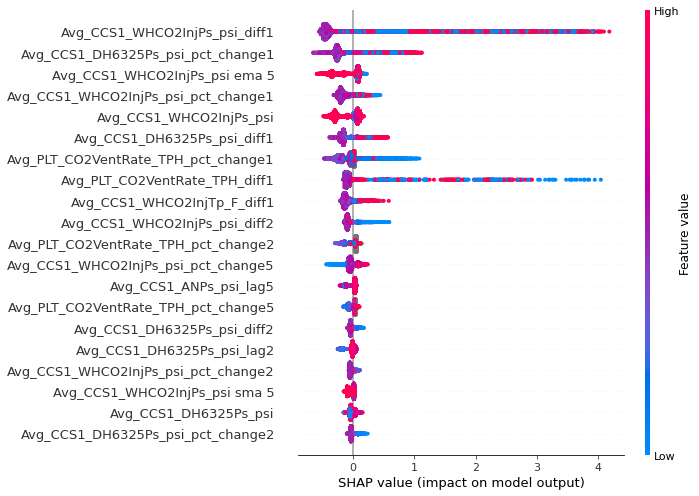

In [13]:
# Plot the SHAP summary plot for the top K features
shap.summary_plot(shap_values, X_train1,
                   plot_size=(10, 7))

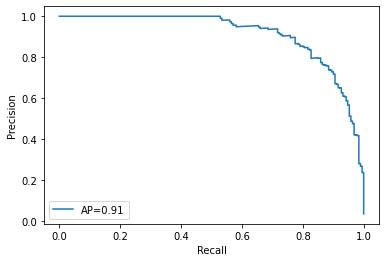

In [14]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val1, y_pred_val1)
average_precision = average_precision_score(y_val1, y_pred_val1)
plt.plot(recall, precision, label='AP={:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [15]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val1, y_pred_val1)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.2940


In [16]:
# predict binary labels using the best threshold
y_pred = (y_pred_val1 >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val1, y_pred)
cm

array([[5268,   28],
       [  35,  156]], dtype=int64)

# 3.2 Hyperparameter tuning

In [17]:
# Keep only the best X features
x_train = x_train[list(clf_top_K_feats)]

In [18]:
# Split the data into training and validation sets (80/20 split)
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# Drop the first 5 rows of the validation set to avoid leakage from lagged features
X_val2 = X_val2.iloc[5:]
y_val2 = y_val2.iloc[5:]

# Create XGBoost DMatrix objects for training and validation data
dtrain2 = xgb.DMatrix(X_train2, y_train2)
dval2 = xgb.DMatrix(X_val2, y_val2)

In [19]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'eval_metric': ['logloss'],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, np.sqrt(sum(y_train2==0)/sum(y_train2==1))]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [88]:
# Initialize empty lists to store results
auc_scores = []
aucpr_scores = []
best_thresholds = []
confusion_matrices = []
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    clf = xgb.train(hyperparams,dtrain2,evals=[(dtrain2, 'train'),(dval2, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=15)

    # Make predictions on the test set
    y_pred_val2 = clf.predict(dval2)

    num_trees = clf.best_ntree_limit
    num_trees_list.append(num_trees)

    # Calculate the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val2, y_pred_val2)
    
    # Calculate AUC and AUCPR
    print(f'AUC={auc(recall, precision)}')
    print(f'AUCPR={average_precision_score(y_val2, y_pred_val2)}')
    auc_scores.append(auc(recall, precision))
    aucpr_scores.append(average_precision_score(y_val2, y_pred_val2))

    # Find the best threshold
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_threshold)

    # Calculate TP, FP, FN using the best threshold
    y_pred2 = (y_pred_val2 > best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val2, y_pred2).ravel()
    confusion_matrices.append((tp, fp, fn))
    print(f'TP={tp}, FP={fp}, FN={fn}')

    print('--'*5)

# Combine the results into a list of dictionaries
clf_results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    clf_results.append({
        'hyperparameters': hyperparams,
        'AUC': auc_scores[i],
        'AUCPR': aucpr_scores[i],
        'Best_threshold': best_thresholds[i],
        'TP': confusion_matrices[i][0],
        'FP': confusion_matrices[i][1],
        'FN': confusion_matrices[i][2],
        'FP+FN': confusion_matrices[i][1]+confusion_matrices[i][2],
    })

AUC=0.9611287213543296
AUCPR=0.9613617753822854
TP=177, FP=26, FN=11
----------
AUC=0.9595744692261093
AUCPR=0.959750490157251
TP=170, FP=18, FN=18
----------
AUC=0.9606134258101361
AUCPR=0.9607787452732116
TP=167, FP=14, FN=21
----------
AUC=0.960065772303867
AUCPR=0.9602094629758775
TP=166, FP=16, FN=22
----------
AUC=0.9585047927563969
AUCPR=0.9587425098967575
TP=162, FP=10, FN=26
----------
AUC=0.9605750947526907
AUCPR=0.9607059366762737
TP=164, FP=14, FN=24
----------
AUC=0.962653843960955
AUCPR=0.9627825439846576
TP=168, FP=16, FN=20
----------
AUC=0.958798775827773
AUCPR=0.9589539385912064
TP=166, FP=15, FN=22
----------
AUC=0.9533153842847388
AUCPR=0.9537181747473312
TP=165, FP=12, FN=23
----------
AUC=0.9557924417756645
AUCPR=0.9560054244695327
TP=164, FP=11, FN=24
----------
AUC=0.9615718930005933
AUCPR=0.9617459227180504
TP=168, FP=15, FN=20
----------
AUC=0.9599570484812578
AUCPR=0.9601053847903532
TP=171, FP=21, FN=17
----------
AUC=0.9544177877914609
AUCPR=0.9548093428906

### Get best results

In [89]:
# Find the best hyperparameters based on the highest AUCPR
clf_best_idx = np.argmax([x['AUCPR'] for x in clf_results])

# Get the best threshold, hyperparameters, and optimal number of trees
clf_best_threshold = clf_results[clf_best_idx]['Best_threshold']
best_hyperparams = clf_results[clf_best_idx]['hyperparameters']
clf_opt_num_trees = num_trees_list[clf_best_idx]

print(clf_results[clf_best_idx])
print(f'Num of trees: {clf_opt_num_trees}')

{'hyperparameters': {'alpha': 5, 'lambda': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 0.7, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror'}, 'AUC': 0.9673056143266382, 'AUCPR': 0.9674205013435294, 'Best_threshold': 0.34920874, 'TP': 176, 'FP': 25, 'FN': 12, 'FP+FN': 37}
Num of trees: 444


In [90]:
# Retrain with best parameters
clf = xgb.train(best_hyperparams, dtrain2, evals=[(dtrain2,'train'),(dval2,'test')], num_boost_round=clf_opt_num_trees)

[0]	train-rmse:0.47655	test-rmse:0.47612
[1]	train-rmse:0.45441	test-rmse:0.45347
[2]	train-rmse:0.43341	test-rmse:0.43199
[3]	train-rmse:0.41353	test-rmse:0.41157
[4]	train-rmse:0.39474	test-rmse:0.39224
[5]	train-rmse:0.37697	test-rmse:0.37389
[6]	train-rmse:0.36016	test-rmse:0.35660
[7]	train-rmse:0.34427	test-rmse:0.34001
[8]	train-rmse:0.32926	test-rmse:0.32431
[9]	train-rmse:0.31507	test-rmse:0.30955
[10]	train-rmse:0.30169	test-rmse:0.29563
[11]	train-rmse:0.28902	test-rmse:0.28237
[12]	train-rmse:0.27714	test-rmse:0.26979
[13]	train-rmse:0.26586	test-rmse:0.25787
[14]	train-rmse:0.25525	test-rmse:0.24654
[15]	train-rmse:0.24531	test-rmse:0.23585
[16]	train-rmse:0.23594	test-rmse:0.22584
[17]	train-rmse:0.22720	test-rmse:0.21642
[18]	train-rmse:0.21898	test-rmse:0.20746
[19]	train-rmse:0.21127	test-rmse:0.19898
[20]	train-rmse:0.20402	test-rmse:0.19107
[21]	train-rmse:0.19719	test-rmse:0.18348
[22]	train-rmse:0.19082	test-rmse:0.17640
[23]	train-rmse:0.18483	test-rmse:0.16975
[2

In [25]:
# Make predictions on training and validation data
y_pred_train2 = clf.predict(dtrain2)
y_pred_val2 = clf.predict(dval2)

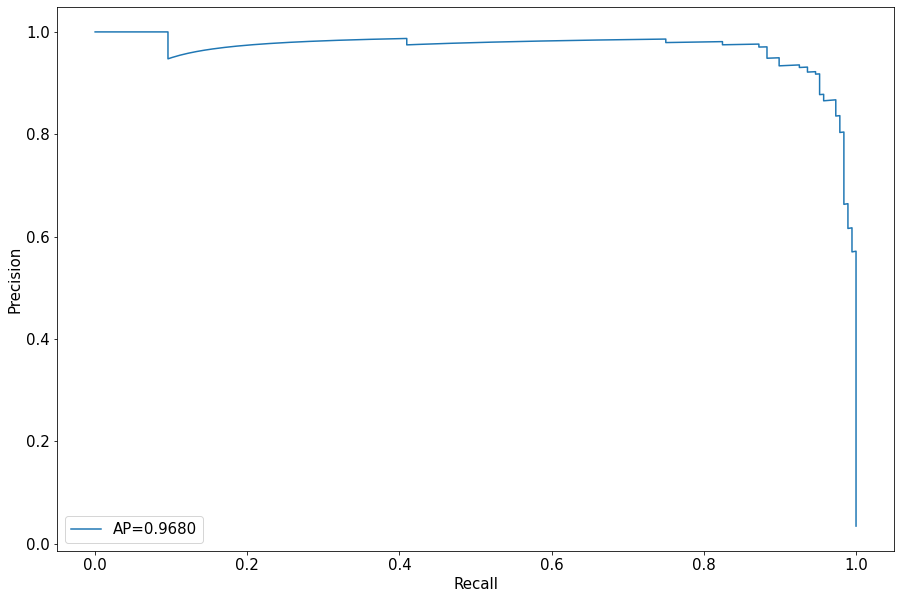

In [28]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val2, y_pred_val2)
average_precision = average_precision_score(y_val2, y_pred_val2)
plt.plot(recall, precision, label='AP={:.4f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [29]:
# predict binary labels using the best threshold
y_pred2 = (y_pred_val2 >= clf_best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val2, y_pred2)
cm

array([[5286,   13],
       [  13,  175]], dtype=int64)

### Plot classifier's SHAP values
Please note that the list below could change due to the random nature of the algorithm

In [91]:
# Rearrange features to group them in image
cols = ['Avg_CCS1_WHCO2InjPs_psi',
 'Avg_CCS1_WHCO2InjPs_psi ema 5',
 'Avg_CCS1_WHCO2InjPs_psi_diff1',
 'Avg_CCS1_WHCO2InjPs_psi_diff2',
 'Avg_CCS1_WHCO2InjPs_psi_diff3',
 'Avg_CCS1_WHCO2InjPs_psi_pct_change1',
 'Avg_CCS1_WHCO2InjPs_psi_pct_change5',
 'Avg_CCS1_WHCO2InjTp_F_diff1',
 'Avg_PLT_CO2VentRate_TPH_diff1',
 'Avg_PLT_CO2VentRate_TPH_pct_change1',
#  'Avg_PLT_CO2VentRate_TPH_pct_change5',
#  'Avg_CCS1_DH6325Ps_psi',
 'Avg_CCS1_DH6325Ps_psi_diff1',
 'Avg_CCS1_DH6325Ps_psi_pct_change1',
 'Pressure diff 5482-5001 ft ema 5',
 'Pressure diff 6837-6720 ft_lag5',
 'Temperature diff 5840-5482 ft_lag3',
 'Temperature diff 6720-5653 ft sma 5'
]

# Calculate shap values
explainer = shap.TreeExplainer(clf)
shap_values = explainer(dtrain2)

order = dtrain2.columns
col2num = {col: i for i, col in enumerate(dtrain2.columns)}
order = list(map(col2num.get, order))

shap.plots.beeswarm(shap_values, show=False, color_bar=True, order=order)
plt.show()

AttributeError: 'DMatrix' object has no attribute 'columns'

## 3.3 Retrain classifier with all available data

In [30]:
# Keep only the best X features
x_train = x_train[list(clf_top_K_feats)]
dfull = xgb.DMatrix(x_train, y_train)

In [31]:
# Retrain the model with the best hyperparameters using all available data
final_clf = xgb.train(best_hyperparams, dfull, num_boost_round=int(clf_opt_num_trees*1.09))
y_pred_train = final_clf.predict(dfull)

In [32]:
y_pred_train = (y_pred_train >= clf_best_threshold).astype(int)

In [34]:

# ERASEEEEEEEEEEEEEEEEEEEEEEEEE


# # Load test set
# df_test = pd.read_csv('./data/test_df_expanded_feats.csv')
# # Keep only the best X features for the test set
# df_test = df_test[list(clf_top_K_feats)]
# # Replace infinite values with NaN
# df_test = df_test.replace([np.inf, -np.inf], np.nan)
# # Convert the test set into an XGBoost DMatrix object
# df_test = xgb.DMatrix(df_test)

# # Make predictions on the test dataset using the trained model
# y_pred_test = final_clf.predict(df_test)

# preds = (y_pred_test >= clf_best_threshold).astype(int)

# sum(preds)

11

# Section 4: Spikes regressor

## 4.1 Feature selection

In [35]:
# Append output of the classifier
df['Classifier output'] = y_pred_train

# Only keep data point classified as positive
y_train = df[df['Classifier output']==1]['Target']
x_train = df[df['Classifier output']==1].drop(['Date', 'Target','Abs Target', 'Target > 2', 'Classifier output'], axis=1)

# Splitting the train and validation datasets
X_train3, X_val3, y_train3, y_val3 = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val3, _, y_val3, _ = train_test_split(X_val3, y_val3, test_size=0.66, shuffle=False)

# Dropping the first 5 rows from validation dataset due to lagged features
X_val3 = X_val3.iloc[5:]
y_val3 = y_val3.iloc[5:]

In [54]:
# Defining XGBoost model semi-optimized hyperparams
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}

dtrain = xgb.DMatrix(X_train3, y_train3)
dval = xgb.DMatrix(X_val3, y_val3)

# Training the XGBoost model on train and validation datasets
spikes_reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:16.39689	test-rmse:19.10186
[1]	train-rmse:15.78196	test-rmse:18.34186
[2]	train-rmse:15.19441	test-rmse:17.79738
[3]	train-rmse:14.67646	test-rmse:17.26793
[4]	train-rmse:14.16189	test-rmse:16.75060
[5]	train-rmse:13.67392	test-rmse:16.20863
[6]	train-rmse:13.21742	test-rmse:15.75890
[7]	train-rmse:12.80879	test-rmse:15.32968
[8]	train-rmse:12.41669	test-rmse:14.90317
[9]	train-rmse:12.02799	test-rmse:14.41683
[10]	train-rmse:11.65432	test-rmse:13.97875
[11]	train-rmse:11.28665	test-rmse:13.61730
[12]	train-rmse:10.97040	test-rmse:13.24494
[13]	train-rmse:10.64235	test-rmse:12.99613
[14]	train-rmse:10.33993	test-rmse:12.64769
[15]	train-rmse:10.07254	test-rmse:12.35521
[16]	train-rmse:9.80056	test-rmse:12.00629
[17]	train-rmse:9.55699	test-rmse:11.81567
[18]	train-rmse:9.28565	test-rmse:11.50571
[19]	train-rmse:9.05399	test-rmse:11.23190
[20]	train-rmse:8.83395	test-rmse:11.00155
[21]	train-rmse:8.61675	test-rmse:10.79594
[22]	train-rmse:8.42226	test-rmse:10.66587
[23]	

In [55]:
# Predicting the target values on train and validation datasets
y_pred_train3 = spikes_reg.predict(dtrain)
y_pred_val3 = spikes_reg.predict(dval)

# Getting feature importance using GAIN and WEIGHT methods
feat_importance = spikes_reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = spikes_reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Getting top 10 SHAP values
explainer = shap.TreeExplainer(spikes_reg)
shap_values = explainer(X_train3)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train3.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

spikes_reg_top_K_feats = list(set(top_10_gain+top_10_weight+top_10_shap))

In [ ]:
# # Saving the top K features
# with open("./metadata/top_K_feat_anomalies_reg.pkl", "wb") as f:
#     pickle.dump(top_K_feat, f)

## 4.2 Hyperparameter tuning

In [60]:
# Split the dataset into train, validation and test sets
X_train4, X_val4, y_train4, y_val4 = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val4, _, y_val4, _ = train_test_split(X_val4, y_val4, test_size=0.5, shuffle=False)

# Remove the first 5 rows from the validation set due to lagged values
X_val4 = X_val4.iloc[5:]
y_val4 = y_val4.iloc[5:]

In [65]:
y_val4

5       8.171528
6       2.092709
7       4.455903
8       1.986870
9       7.955556
         ...    
163     2.792361
164    -2.872917
165    20.229167
166    22.526041
167    -4.688542
Name: Target, Length: 163, dtype: float64

In [61]:
3 # Create DMatrix objects for the train and validation sets
dtrain = xgb.DMatrix(X_train4, y_train4)
dval = xgb.DMatrix(X_val4, y_val4)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [69]:
# # Extract the ground truth target values for the validation set
# y_val4_true = df[df['Classifier output']==1]['Target']

# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

# Iterate over all hyperparameter combinations and train and evaluate the XGBoost model on the validation set
for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    spikes_reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train4 = spikes_reg.predict(dtrain)
    y_pred_val4 = spikes_reg.predict(dval)

    num_trees = spikes_reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val4, y_pred_val4))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_val4, y_pred_val4, sample_weight=np.abs(y_val4)/sum(np.abs(y_val4)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

    print('--'*5)
    
# Combine the results into a list of dictionaries
spikes_results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    spikes_results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 7.23
MAPE: 0.29%
----------
RMSE: 7.38
MAPE: 0.29%
----------
RMSE: 7.43
MAPE: 0.30%
----------
RMSE: 7.54
MAPE: 0.30%
----------
RMSE: 7.39
MAPE: 0.30%
----------
RMSE: 7.52
MAPE: 0.31%
----------
RMSE: 7.45
MAPE: 0.30%
----------
RMSE: 7.45
MAPE: 0.31%
----------
RMSE: 7.51
MAPE: 0.31%
----------
RMSE: 7.76
MAPE: 0.31%
----------
RMSE: 7.35
MAPE: 0.30%
----------
RMSE: 7.50
MAPE: 0.30%
----------
RMSE: 7.52
MAPE: 0.30%
----------
RMSE: 7.45
MAPE: 0.30%
----------
RMSE: 7.36
MAPE: 0.30%
----------
RMSE: 7.60
MAPE: 0.31%
----------
RMSE: 7.27
MAPE: 0.30%
----------
RMSE: 7.60
MAPE: 0.30%
----------
RMSE: 7.44
MAPE: 0.31%
----------
RMSE: 7.49
MAPE: 0.30%
----------
RMSE: 7.46
MAPE: 0.30%
----------
RMSE: 7.51
MAPE: 0.31%
----------
RMSE: 7.33
MAPE: 0.29%
----------
RMSE: 7.48
MAPE: 0.30%
----------
RMSE: 7.42
MAPE: 0.30%
----------
RMSE: 7.85
MAPE: 0.32%
----------
RMSE: 7.40
MAPE: 0.30%
----------
RMSE: 7.72
MAPE: 0.31%
----------
RMSE: 7.49
MAPE: 0.30%
----------
RMSE: 7.49
MAP

In [70]:
# Find the best hyperparameters based on the highest AUCPR
spikes_best_idx = np.argmin([x['RMSE'] for x in spikes_results])

# Get the best threshold, hyperparameters, and optimal number of trees
spikes_best_hyperparams = spikes_results[spikes_best_idx]['hyperparameters']
spikes_opt_num_trees = num_trees_list[spikes_best_idx]

print(spikes_results[spikes_best_idx])
print(f'Num of trees: {spikes_opt_num_trees}')

{'hyperparameters': {'alpha': 1, 'lambda': 1, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror'}, 'RMSE': 7.23173782616161, 'MAPE': 0.2921939794214686}
Num of trees: 91


### Test regressor in the final 15%

In [73]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

# Removing first 5 rows of test set and corresponding labels due to lagged features
X_test4 = X_test4.iloc[5:]
y_test4 = y_test4.iloc[5:]

dtrain = xgb.DMatrix(X_train4[spikes_reg_top_K_feats], y_train4)
dval = xgb.DMatrix(X_test4[spikes_reg_top_K_feats], y_test4)

# Training the final model on best hyperparameters and optimal number of trees
spikes_reg = xgb.train(spikes_best_hyperparams,dtrain,num_boost_round=int(spikes_opt_num_trees*1.09))

In [75]:
# Predicting on the validation set
preds_reg=spikes_reg.predict(dval)
rmse_class_1 = np.sqrt(mean_squared_error(y_test4, preds_reg))
rmse_class_1

6.3682598630365375

In [77]:
# Calculating the mean absolute percentage error for class 1
MAPE_class_1 = mean_absolute_percentage_error(y_test4, preds_reg, sample_weight=np.abs(y_test4/sum(np.abs(y_test4))))
MAPE_class_1

0.28596346620246926

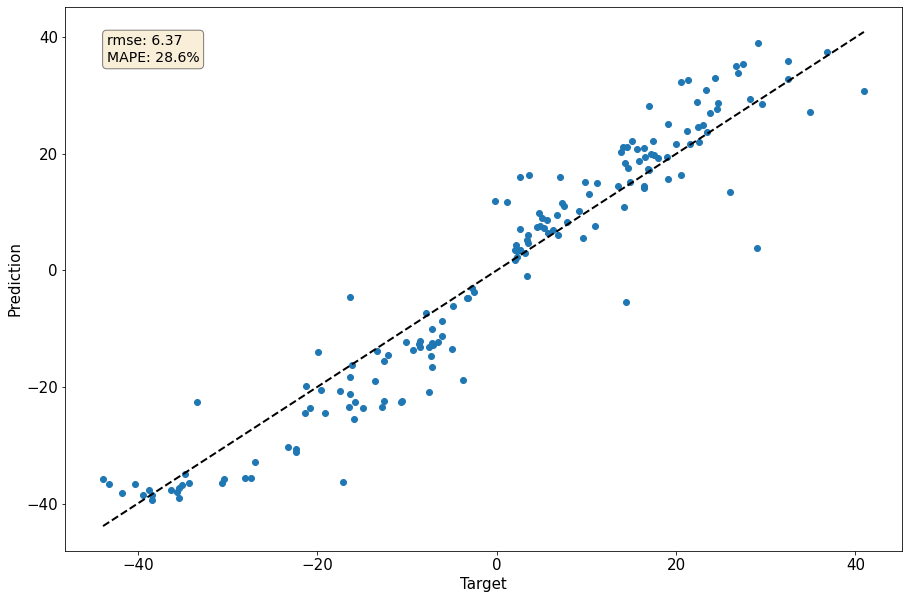

In [80]:
plt.scatter(y_test4, preds_reg)
textstr = 'rmse: ' + format(rmse_class_1, '.3g') +'\n' + 'MAPE: ' + format(100 * MAPE_class_1, '.3g') + '%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

# Add a diagonal line
min_value = min(y_test4.min(), preds_reg.min())
max_value = max(y_test4.max(), preds_reg.max())
plt.plot([min_value, max_value], [min_value, max_value], 'k--', lw=2)

plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
# Reordering columns for the SHAP plot
cols = [
'Avg_CCS1_WHCO2InjPs_psi',
'Avg_CCS1_WHCO2InjPs_psi_diff1',
'Avg_CCS1_WHCO2InjPs_psi_lag1',
'Avg_CCS1_WHCO2InjPs_psi_pct_change1',
'Log abs Avg_CCS1_WHCO2InjPs_psi sma 5',

'Avg_CCS1_WHCO2InjTp_F',
'Avg_CCS1_WHCO2InjTp_F_lag1',
'Avg_CCS1_WHCO2InjTp_F_diff1',
'Avg_CCS1_WHCO2InjTp_F_pct_change1',

'Avg_PLT_CO2VentRate_TPH',

'Avg_CCS1_DH6325Ps_psi_pct_change1',
'Avg_CCS1_DH6325Ps_psi_lag1',
'Avg_CCS1_DH6325Ps_psi_diff1',
'Avg_CCS1_DH6325Ps_psi_pct_change2',

'Avg_VW1_Z10D5001Ps_psi_pct_change5',

'Pressure diff 7061-6982 ft_pct_change1',
'Pressure diff 5482-5001 ft_pct_change3',
'Temperature diff 6720-6416 ft_pct_change2',
'Temperature diff 6982-6720 ft_diff1'
]

X_train4 = X_train4[cols]
dfull = xgb.DMatrix(x_train, y_train)

# Training the XGBoost model on the final dataset
spikes_reg = xgb.train(params,dfull,num_boost_round=int(spikes_reg.best_ntree_limit*1.09))

# Calculate shap values
explainer = shap.TreeExplainer(spikes_reg)
shap_values = explainer(x_train)

# Ordering the columns for the SHAP plot
order = x_train.columns
col2num = {col: i for i, col in enumerate(x_train)}
order = list(map(col2num.get, order))

# Plotting the SHAP values
shap.plots.beeswarm(shap_values, max_display=len(cols), show=False, color_bar=True, order=order)
plt.show()

# 4.3 Retrain final spike regressor with 100% of the train data

In [85]:
y_train = df[df['Classifier output']==1]['Target']
x_train = df[df['Classifier output']==1][spikes_reg_top_K_feats]

dtrain = xgb.DMatrix(x_train, y_train)
spikes_reg = xgb.train(spikes_best_hyperparams, dtrain, num_boost_round=int(spikes_opt_num_trees*1.09))

# reg.save_model('./output/regressor_class1/positive_class_xgb_final_regressor.json')

# Secion 5: Low-values regressor

## 5.1 Feature selection

In [ ]:
# Append output of the classifier
df['Classifier output'] = y_pred_train

# Only keep data point classified as positive
y_train = df[df['Classifier output']==1]['Target']
x_train = df[df['Classifier output']==1].drop(['Date', 'Target','Abs Target', 'Target > 2', 'Classifier output'], axis=1)

# Splitting the train and validation datasets
X_train3, X_val3, y_train3, y_val3 = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val3, _, y_val3, _ = train_test_split(X_val3, y_val3, test_size=0.66, shuffle=False)

# Dropping the first 5 rows from validation dataset due to lagged features
X_val3 = X_val3.iloc[5:]
y_val3 = y_val3.iloc[5:]

# Section 6: Testing

In [ ]:
# Load test set
# df_test = pd.read_csv('./data/test_df_expanded_feats.csv')
# Keep only the best X features for the test set
# df_test = df_test[list(top_K_feat)]
# # Replace infinite values with NaN
# df_test = df_test.replace([np.inf, -np.inf], np.nan)
# # Convert the test set into an XGBoost DMatrix object
# df_test = xgb.DMatrix(df_test)

# Make predictions on the test dataset using the trained model
y_pred_test = final_clf.predict(df_test)

In [ ]:
preds = (y_pred_test >= best_threshold).astype(int)

In [ ]:
sum(preds)

11